<a href="https://colab.research.google.com/github/andrefsc/SDC_M04/blob/main/M06_Tarea_Individual_P2_AndreCastanho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Master en Inteligência Artificial en el Deporte, Edición 8**

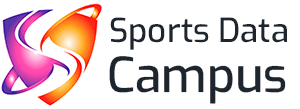

__Tarea Individual Módulo 6 - Parte 2__
````
Análisis de sentimiento con BERT : Análisis de sentimiento en tweets

La segunda parte de la tarea consiste en utilizar el mismo modelo DistilBERT para realizar un análisis de sentimiento con el dataset que contiene tweets.

Se tiene que ejecutar el notebook que se os proporciona para realizar el análisis de sentimiento, entender los pasos y comparar
los resultados en este dataset con los resultados en el dataset anterior e intentar explicar los motivos por los que las métricas
de evaluación bajan en el dataset que contiene tweets.

En el siguiente notebook tenéis todo el código con comentarios y unas celdas donde podéis explorar los resultados
y hacer la comparación: Tarea_Modulo_6_Parte_2.ipynb.
---

André Silveira Castanho
April, 2024

`````

**Explicación del Código**

````
Este código permite acceder a los archivos almacenados en Google Drive desde un cuaderno de Colab, montando el Google Drive
como un sistema de archivos en la ruta especificada (/content/drive).

````

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


El ambiente virtual de Google Colab ya incluye muchas de las bibliotecas comúnmente usadas en tareas de inteligencia artificial.
No obstante, es necesario añadir la biblioteca **transformers** de Huggingface y **tqdm**, que facilita la visualización de barras de progreso en bucles for.

In [2]:
!pip install transformers
!pip install tqdm

# 0. Imports

En la sección **Imports** agrupamos todas las librerías y clases que debemos importar en esta tarea.

In [3]:
# import basic libraries for data science
import pandas as pd # para manipulación y análisis de datos
import numpy as np # para operaciones matemáticas de alto nivel
import matplotlib.pyplot as plt # para la visualización de datos

# import torch and transformers
import torch # el framework principal para operaciones con tensores y redes neuronales
from torch import cuda # de PyTorch, para operaciones en GPUs
from torch.utils.data import Dataset, DataLoader # para manejar y cargar datos en formato adecuado para entrenar modelos con PyTorch
from transformers import AutoModelForSequenceClassification, AutoTokenizer # de la biblioteca transformers, para cargar modelos preentrenados
                                                                           # y tokenizadores que se ajustan automáticamente al modelo

# import different metrics for evaluation
# Para evaluar el rendimiento de modelos de clasificación
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, accuracy_score, f1_score

# import tqdm to track progress
# para mostrar barras de progreso en bucles, facilitando el seguimiento de largas ejecuciones
from tqdm import tqdm
from tqdm.notebook import tqdm

# import some python modules required for some of the utility functions
import itertools # ofrece construcciones eficientes de bucles
import re # para operaciones de expresiones regulares
import os # para interactuar con el sistema operativo, como manejo de archivos y directorios

# 1. Functions Utils

En la sección **Functions Utils** se encuentran varias funciones de utilidad con sus docstrings que se utilizarán a largo de la implementación para preprocesar y limpiar datos y también evaluar los resultados.

**1.1. Text Processing and Cleaning Functions**

**Función: encode_sentiment**

````
Función que codifica etiquetas de sentimiento textual a formato numérico.
Recibe un argumento sentiment, que es una cadena de texto que puede ser "positive" o cualquier otro valor que se considerará negativo.
Retorna 1 si el sentimiento es "positive" y 0 en cualquier otro caso.
Esto es útil para convertir datos categóricos de texto en formatos numéricos que pueden ser procesados por algoritmos de aprendizaje automático.

````

In [4]:
def encode_sentiment(sentiment):
  """
  Label encode sentiment.

  Parameters
  ----------
  sentiment: str, sentiment {"positive", "sentiment"}

  Returns
  -------
  int, 1's for positive and 0's for negative

  """
  if sentiment == "Positive":
    return 1
  else:
    return 0

**Función: is_ascii**

````
Función que determina si un carácter es de tipo ASCII.
Recibe como parámetro w, que es un carácter en forma de cadena de texto.
Retorna True si el carácter puede ser codificado en ASCII, y False si no puede, lo cual indicaría que el carácter incluye símbolos o letras especiales que no están incluidos en la tabla ASCII estándar.
Este tipo de función es útil para filtrar o validar textos que deben cumplir con ciertos estándares de codificación.
````

In [5]:
def is_ascii(w):
  """
  Check if character is ascii type.

  Parameters
  ----------
  w: str, character

  Returns
  -------
  bool, True if character is ascii. False otherwise.
  """
  try:
    w.encode("ascii")
    return True
  except UnicodeEncodeError:
    return False

**Función: text_cleaning**
````
Función que utiliza para limpiar un texto de símbolos, puntuación y otros elementos no deseados, facilitando su procesamiento posterior en tareas de análisis de texto. La función text_cleaning realiza las siguientes operaciones sobre el texto que recibe como parámetro text:

1. Eliminar formatos de cadena como saltos de línea (\n) y tabulaciones (\t),reemplazándolos por un punto y espacio para mantener la separación de las sentencias.
2. Excluir palabras con caracteres no-ASCII, es decir, filtrar palabras que contengan caracteres especiales o acentuados que no se encuentren en la codificación ASCII estándar.
3. Eliminar direcciones de correo electrónico que comienzan con "@", y URLs completas que comiencen con "http" o "www".
4. Remover puntuación, manteniendo únicamente puntos y comas para no alterar el fin de las sentencias ni los elementos decimales, y convertir todo el texto a minúsculas para homogeneizar la capitalización.

El resultado es un texto limpio (cleaned_text) que solamente contiene palabras en letras minúsculas y caracteres ASCII, con puntos y comas como única puntuación, lo cual simplifica análisis posteriores como la tokenización o el modelado de lenguaje natural.
````

In [6]:
def text_cleaning(text):
  """
  Clean text from symbols, punctuation, etc.

  Parameters
  ----------
  text: string, text data

  Returns
  -------
  cleaned_text: string, cleaned text data
  """
  # remove string formatting '\n' or '\t'
  tmp_text = re.sub(r'\n+', '. ', text)
  tmp_text = re.sub(r'\t+', '. ', text)
  # remove words with non-ascii characters
  tmp_text = " ".join([word for word in tmp_text.split() if is_ascii(word)])
  # remove email address
  tmp_text = " ".join([word for word in tmp_text.split() if not word.startswith("@")])
  # remove urls
  tmp_text = re.sub(r'http\S+', '', tmp_text, flags=re.MULTILINE)
  tmp_text = re.sub(r'www\S+', '', tmp_text, flags=re.MULTILINE)
  # remove punctuation but . (to split sentences)
  cleaned_text = re.sub('[^A-Za-z.,]+', ' ', tmp_text)
  # lowercase
  cleaned_text = cleaned_text.lower()

  return cleaned_text

**1.2. Evaluation Functions**

**Función: plot_confusion_matrix**

````
Función que permite visualizar la matriz de confusión de un modelo de clasificación, que ayuda a evaluar su precisión.
Puede normalizar la matriz para comparar proporciones y utiliza un mapa de colores para representar los valores.
Los elementos de la matriz se anotan con valores numéricos, ajustando el color del texto para mejorar la legibilidad según el fondo.

Nota:
interpolation='nearest': Este argumento especifica el método de interpolación para renderizar la imagen.
La opción 'nearest' utiliza el valor del píxel más cercano para colorear cada píxel visualizado, lo que ayuda a mantener
la fidelidad de los valores originales sin suavizarlos. Esto es ideal para visualizar claramente cada valor de la matriz sin efectos de interpolación entre píxeles.

````

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

# 2. Settings

En la sección **Settings** definimos variables y objetos que utilizaremos en el desarrollo y queremos tener agrupados en el mismo lugar.

**Definición de Variables Clave:**

````
MAX_LEN = 256: Establece el número máximo de tokens a 256 para los textos que se procesarán, lo cual es importante para definir la longitud de entrada que el modelo puede manejar.
BATCH_SIZE = 64: Define el tamaño del lote para el entrenamiento del modelo, lo que afecta directamente la memoria que se consumirá y la velocidad de entrenamiento.
SEED = 42: Fija una semilla para el generador de números aleatorios para garantizar resultados reproducibles.

````

In [8]:
# Defining some key variables that will be used later on
MAX_LEN = 256 # max number of tokens
BATCH_SIZE = 64
SEED = 42 # for reprodudible results

**Inicialización del Tokenizador:**

````
Carga un tokenizador preentrenado del modelo 'distilbert-base-uncased-finetuned-sst-2-english', que es útil para convertir texto
en tokens que el modelo de Transformers puede procesar.
````

In [9]:
# Initialiaze model tokenizer
TOKENIZER = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

**Configuración del Dispositivo:**

````
Determina si se utilizará una GPU (con CUDA) o una CPU para el entrenamiento, dependiendo de la disponibilidad.
Esto es crucial para la eficiencia en el entrenamiento, ya que las GPUs permiten una computación más rápida.

````

In [10]:
# Setting up the device for GPU usage if available
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# 3. Data

En la sección **Data** necesitamos cargar los datos en un dataframe de pandas, codificar el sentimiento y limpiar el texto.

Podeis hacer uso de las funciones de utilidad **encode_sentiment()** y **text_cleaning()**.

**Explicación del Código**

````
Este código carga un conjunto de datos desde un archivo CSV ubicado en un directorio específico de Google Drive.

Se utiliza la biblioteca pandas para leer el archivo, especificando un codificación utf-8 para gestionar correctamente los caracteres especiales.

Tras cargar los datos, se elimina la columna id mediante el método .drop("id", axis=1), lo que simplifica el DataFrame al descartar información no necesaria.

Finalmente, se visualizan las vinte primeras filas del DataFrame con raw_data.head(20), ofreciendo una vista preliminar de los datos cargados.

````

In [11]:
# Carregar os dados do arquivo CSV no diretório de GoogleDrive
file_path = '/content/drive/MyDrive/Colab_notebooks/Files/02_train.csv'
raw_data = pd.read_csv(file_path,encoding='utf-8').drop("id", axis=1)

raw_data.head(20)

,text,polarity
0,Recorriendo el #CampNou🏟 https://t.co/ZKZ1ERaiZS,Neutral
1,@FCBarcelona fera desde pequeno😲😲,Neutral
2,@sport Y el barca que haria sin Messi????? Ni ...,Negative
3,Please RT!! #barcelona #fcbarcelona #Barca #fc...,Neutral
4,"@NostradamusFCB Si parce que miedo, sólo el ba...",Neutral
5,@Matt_Santangelo Mino= No Barca.,Neutral
6,Pero cuando dicen que os ganará el Barça acaba...,Neutral
7,@RoussGame Te as enterado que an robado en la ...,Negative
8,"Qué maravilla que este chico tocado por Dios, ...",Positive
9,@natxinho @jorgeneo @F_Reymundo totalmente! Aq...,Negative


**Explicación del Código**

````
El método raw_data.info(), se emplea para obtener un resumen conciso del DataFrame raw_data.
Este método es extremadamente útil para obtener información fundamental sobre la estructura y las características del DataFrame,
especialmente antes de proceder con análisis más detallados o la limpieza de datos.

````

In [12]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      411 non-null    object
 1   polarity  411 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB


**Explicación del Código**

````
Ahora se muestra el número total de tweets presentes en el DataFrame raw_data, utilizando raw_data.shape[0] para obtener
la cantidad de filas, que representa los tweets.
````

In [13]:
print(f"Number of tweets: {raw_data.shape[0]}")

Number of tweets: 411


**Explicación del Código**

````
Aqui se  muestra la frecuencia de cada valor único en la columna polarity del DataFrame raw_data.
Este método es esencial para entender la distribución de los datos en la columna especificada, proporcionando un conteo exacto de cuántas veces aparece cada valor de polarity, que generalmente representa diferentes categorías o clasificaciones dentro del conjunto de datos.
Esta información es crítica para análisis preliminares, especialmente en tareas de clasificación o cuando se necesita verificar el balance de las clases en los datos.
````

In [14]:
raw_data.polarity.value_counts()

polarity
Neutral     208
Negative    142
Positive     61
Name: count, dtype: int64

**Explicación del Código**

````
Se presenta una visualización de la distribución de valores en la columna 'polarity' del DataFrame raw_data.
Este gráfico facilita la visualización rápida de la cantidad de tweets por cada categoría de polaridad, siendo útil para entender
la distribución general de sentimientos expresados en los tweets.
````

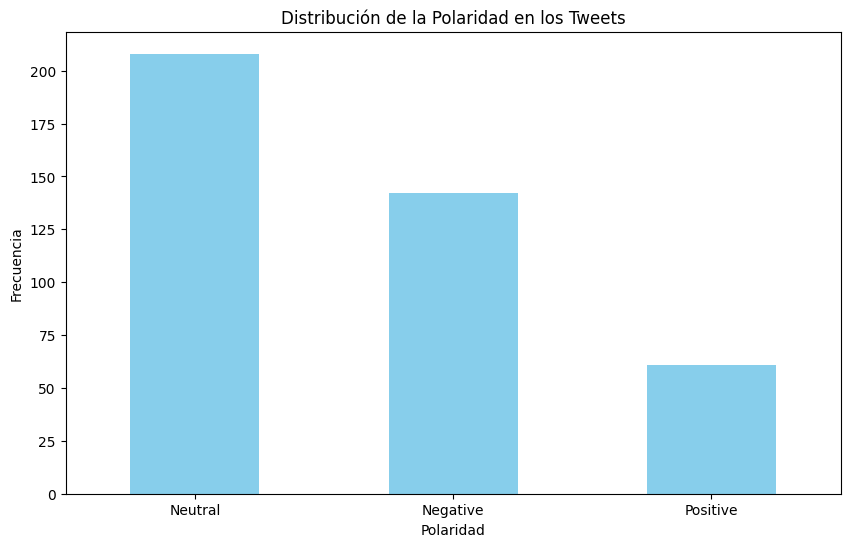

In [15]:
# Conteo de frecuencias de los valores en la columna 'polarity'
polarity_counts = raw_data.polarity.value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
polarity_counts.plot(kind='bar', color='skyblue')  # Gráfico de barras con color azul cielo

# Añadir títulos y etiquetas
plt.title('Distribución de la Polaridad en los Tweets')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)

plt.show()

**Explicación del Código**

````
Se muestra los porcentajes de cada valor único en la columna 'polarity' del DataFrame raw_data, utilizando normalize=True
para obtener proporciones que luego multiplica por 100 para convertir en porcentajes.
````

In [16]:
# Calcular los porcentajes de los valores en la columna 'polarity'
polarity_percentages = raw_data.polarity.value_counts(normalize=True) * 100  # normalize=True calcula la proporción

# Imprimir los porcentajes con un formato adecuado
print("Porcentajes de Polaridad en los Tweets:")
print(polarity_percentages.map("{:.2f}%".format))

Porcentajes de Polaridad en los Tweets:
polarity
Neutral     50.61%
Negative    34.55%
Positive    14.84%
Name: proportion, dtype: object


**Objetivo :**

````
Queremos comparar el desempeño del modelo utilizado en la parte 1 de la tarea. Este modelo estaba ajustado para una tarea de clasificación binaria.
Sin embargo, vemos como este dataset esta preparado para un problema de clasificación multiclase.

Nos quedaremos únicamente con los ejemplos positivos y negativos para poder realizar la comparación.

````

**Explicación del Código**

````
Se filtra y elimina los registros donde la columna 'polarity' tiene el valor "Neutral" del DataFrame raw_data, creando un nuevo DataFrame data_subset que solo incluye los datos con polaridades positivas o negativas.
Este paso es crucial para enfocar análisis subsiguientes en comparaciones claras entre sentimientos positivos y negativos.

````

In [17]:
# get rid of neutral examples
data_subset = raw_data.loc[raw_data.polarity != "Neutral"]
data_subset.head()

,text,polarity
2,@sport Y el barca que haria sin Messi????? Ni ...,Negative
7,@RoussGame Te as enterado que an robado en la ...,Negative
8,"Qué maravilla que este chico tocado por Dios, ...",Positive
9,@natxinho @jorgeneo @F_Reymundo totalmente! Aq...,Negative
14,@ngomez9 @FirmaEspn @EJerezESPN @kenneth_garay...,Negative


**Explicación del Código**

````
Aqui se realiza un conteo de las frecuencias de los valores en la columna 'polarity' del DataFrame data_subset, luego calcula
los porcentajes de estas frecuencias usando normalize=True para transformar los conteos en proporciones, que multiplica
por 100 para obtener porcentajes.

Este análisis ayuda a entender mejor la intensidad y la proporción de los sentimientos expresados en los tweets analizados.
````

In [18]:
data_subset.polarity.value_counts()

polarity
Negative    142
Positive     61
Name: count, dtype: int64

In [19]:
# Calcular los porcentajes de los valores en la columna 'polarity'
polarity_percentages = data_subset.polarity.value_counts(normalize=True) * 100  # normalize=True para obtener porcentajes

# Imprimir los porcentajes con un formato adecuado
print("Porcentajes de Polaridad en el Subconjunto de Datos:")
print(polarity_percentages.map("{:.2f}%".format))

Porcentajes de Polaridad en el Subconjunto de Datos:
polarity
Negative    69.95%
Positive    30.05%
Name: proportion, dtype: object


**Explicación del Código**

````
Aqui se prepara un subconjunto de datos para análisis, primero asegurándose de evitar advertencias al trabajar con copias de DataFrames
y luego codificando los sentimientos en la columna 'polarity' para su análisis numérico.

````

In [20]:
# Crear una copia explícita del subconjunto para evitar la advertencia SettingWithCopyWarning
# si data_subset es una vista de otro DataFrame.
data_subset = data_subset.copy()

# Codificar el sentimiento usando el método .map() para aplicar la función encode_sentiment
# Utilizar .loc[] para asignaciones seguras especificando todas las filas (:) y la columna 'polarity'
data_subset.loc[:, 'polarity'] = data_subset['polarity'].map(encode_sentiment)

# Mostrar las primeras 15 filas del DataFrame para verificar los cambios realizados
data_subset.head(20)

,text,polarity
2,@sport Y el barca que haria sin Messi????? Ni ...,0
7,@RoussGame Te as enterado que an robado en la ...,0
8,"Qué maravilla que este chico tocado por Dios, ...",1
9,@natxinho @jorgeneo @F_Reymundo totalmente! Aq...,0
14,@ngomez9 @FirmaEspn @EJerezESPN @kenneth_garay...,0
15,¡DE PIE DAMAS Y CABALLEROS! 💃🕴👏\n#HOY se cumpl...,1
16,@jotajordi13 Si..pero la liga y la copa os com...,0
18,Deportes Cuatro: SOIS UNA MIERDA\n\nEstán tach...,0
19,"⚽️🇪🇸| Barça\n\nEl partido de 'Dinho' ese día, ...",1
23,¡TREMENDO! 🙌 La brutal exhibición de Koke en e...,1


**Explicación del Código**

````
Por final se limpia los datos de un subconjunto para su posterior análisis: realiza una copia de data_subset y restablece los
índices para eliminar discontinuidades.
A continuación, aplica una función de limpieza text_cleaning a la columna "text", que procesa y normaliza el texto.
````

In [21]:
### clean tweets
cleaned_data = data_subset.copy().reset_index(drop=True)
cleaned_data["text"] = cleaned_data["text"].map(text_cleaning)

cleaned_data.head(20)

,text,polarity
0,y el barca que haria sin messi ni rotaciones l...,0
1,te as enterado que an robado en la tienda del ...,0
2,"maravilla que este chico tocado por dios, jueg...",1
3,totalmente solo tiene favores arbitrales el so...,0
4,ahora el psg es paquete. pobre ignorante. cuan...,0
5,pie damas y caballeros hoy se cumplen del debu...,1
6,si..pero la liga y la copa os comeis un mojon ...,0
7,deportes cuatro sois una mierda tachando de ve...,0
8,el partido de dinho ese fue de los que hacen r...,1
9,la brutal de koke en el rondo del entrenamient...,1


**Explicación del Código**

````
Se obtene un resumen conciso del DataFrame cleaned_data, incluyendo la cantidad total de entradas, el nombre de cada columna,
el número de valores no nulos observados y el tipo de dato de cada columna.
````

In [22]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      203 non-null    object
 1   polarity  203 non-null    object
dtypes: object(2)
memory usage: 3.3+ KB


# 4. Dataset and Dataloader

En la sección **Dataset and Dataloader** vamos a crear un dataset de Pytorch del tipo map-iterable que utilizaremos para almacenar los datos y procesarlos de acuerdo a los requirimientos del modelo.

Después creamos un objeto **DataLoader** de Pytorch que toma el dataset para poder pasar ejemplos al modelo en lotes o batches.

---

__Clase DistilBertDataset__

La clase **DistilBertDataset** toma como argumentos un dataframe con los datos, el tokenizador del modelo y el número de máximo de tokens que definimos en la sección **Config**.

El método **__getitem__()** toma como parámetro un índice de los datos en el dataset, extrae el ejemplo correspondiente del dataframe y utiliza la función **encode_plus()** del tokenizador para procesar los inputs de acuerdo a los requerimientos de DistilBERT ( special tokens [CLS] y [SEP], truncation, padding, etc.). Este método devuelve un diccionario de python con los tensores que continen los inputs ids, los attention masks y el sentimiento codificado.

El método **__len__()** simplemente devuelve el número de ejemplos en el dataset.

---

__DataLoader__

El **DataLoader** viene a ser un generador que devulve lotes de tamaño `BATCH_SIZE` para alimentar el modelo.

En sus parámetros podemos definir el tamaño de lote o batch size, si seleccionar de forma aleatoria los ejemplos a incluir en el batch o no (recomendable al realizar un entrenamiento) y también el número de workers a utilizar (2 para Google Colab).

---

In [23]:
class DistilBertDataset(Dataset):
  """Dataset iterable y mapeable personalizado de Pytorch para análisis de sentimientos con DistilBERT."""

  def __init__(self, dataframe, tokenizer, max_len):
      self.len = len(dataframe)  # Guarda el número de filas en el dataframe para usarlo en __len__
      self.data = dataframe  # Asigna el dataframe pasado como argumento a la instancia
      self.tokenizer = tokenizer  # Asigna el tokenizador para DistilBERT pasado como argumento a la instancia
      self.max_len = max_len  # Establece la longitud máxima de los tokens para procesamiento

  def __getitem__(self, index):
      text = str(self.data['text'].loc[index])  # Extrae el texto de la fila indicada por el índice
      text = " ".join(text.split())  # Normaliza los espacios en blanco, asegurando que solo haya espacios simples entre palabras
      inputs = self.tokenizer.encode_plus(  # Tokeniza el texto utilizando el tokenizador de DistilBERT
          text,
          None,  # No se pasa un segundo texto (para pares de texto, como en tareas de pregunta-respuesta)
          add_special_tokens=True,  # Añade tokens especiales para DistilBERT (CLS, SEP)
          max_length=self.max_len,  # Trunca o rellena el texto para que tenga exactamente max_len elementos
          padding='max_length',  # Rellena con ceros hasta alcanzar max_len si el texto es más corto
          return_token_type_ids=False,  # No retorna token_type_ids (DistilBERT no los usa)
          truncation=True  # Permite la truncación para textos que excedan max_len
      )
      ids = inputs['input_ids']  # Obtiene los IDs de los tokens
      mask = inputs['attention_mask']  # Obtiene la máscara de atención, que indica a DistilBERT dónde hay tokens significativos y dónde padding

      return {
          'ids': torch.tensor(ids, dtype=torch.long),  # Convierte los IDs de tokens a tensores de PyTorch y los retorna
          'mask': torch.tensor(mask, dtype=torch.long),  # Convierte la máscara de atención a tensor y la retorna
          'targets': torch.tensor(self.data['polarity'].loc[index], dtype=torch.long)  # Convierte la polaridad (etiqueta) a tensor y la retorna
      }

  def __len__(self):
      return self.len  # Retorna la longitud del dataset, necesaria para la iteración durante el entrenamiento


**Explicación del Código**

````
Se inicializa una instancia de DistilBertDataset utilizando datos preprocesados, un tokenizador y una longitud máxima
de tokens definida. Se emplea cleaned_data como el DataFrame que contiene los textos ya limpios y normalizados.
El TOKENIZER utilizado es específico para DistilBERT, preparando los textos adecuadamente para este modelo.

La longitud máxima de tokens, MAX_LEN, asegura que todos los inputs tengan el mismo tamaño, aplicando truncamiento o padding
según sea necesario. Este objeto dataset es ahora adecuado para usar en entrenamientos de modelos o evaluaciones,
manteniendo la consistencia y la calidad de los datos para el procesamiento de lenguaje natural con DistilBERT.
````

In [24]:
# Crea una instancia de DistilBertDataset con los datos limpios, el tokenizador y el número máximo de tokens
dataset = DistilBertDataset(dataframe=cleaned_data, tokenizer=TOKENIZER, max_len=MAX_LEN)

**Explicación del Código**

````
Imprime información sobre el sexto elemento del conjunto de datos dataset. Muestra los IDs de entrada, las máscaras
de atención y el objetivo (sentimiento) para ese elemento en particular. Esto permite una rápida verificación de cómo están
estructurados y almacenados los datos en el conjunto de datos personalizado para el análisis de sentimientos con DistilBERT.
````

In [25]:
print("---- Visually inspecting 5th element ----")
print("\n")
print(f"Input ids: {dataset[4]['ids']}")
print("\n")
print(f"Attention masks: {dataset[4]['mask']}")
print("\n")
print(f"Target: {dataset[4]['targets']}")
print("------------------------------------------")

---- Visually inspecting 5th element ----


Input ids: tensor([  101,  6289,  6525,  3449,  8827,  2290,  9686,  6643, 12647,  2063,
         1012, 13433, 13578, 21591,  2063,  1012, 12731, 28574,  3449,  5292,
        25325,  5657, 16839,  2000,  3597,  3449,  8827,  2290,  1061,  8254,
        11265, 24335,  2906,  1012,  6289,  6525,  1053,  3449,  6921,  8840,
        12005, 10020,  2080,  9686,  4895,  6643, 12647,  2063,  2139,  1041,
        15549,  6873,  1012, 14262, 28697, 10446,  9365,  1037, 14163,  8743,
         2063,  9686,  4748, 14503,  3085,  2566,  2080, 14262, 10228,  3406,
         1061,  2053,  9078, 22799,  2099,  5869,  2522, 20939,  9686, 15544,
        19307,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
         

**Explicación del Código**

````
Establece los parámetros para el DataLoader, que se utiliza para cargar datos en lotes durante el entrenamiento
de un modelo de aprendizaje automático.

Se definen tres parámetros principales: el tamaño del lote (batch_size), si se deben mezclar los datos (shuffle),
y el número de subprocesos (num_workers) que se utilizarán para cargar los datos en paralelo.

Luego, se crea el DataLoader usando estos parámetros junto con el conjunto de datos previamente creado dataset.
Esto facilita la carga eficiente y escalable de datos para el entrenamiento del modelo.
````

In [26]:
# define dataloader params
dataloader_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 2
                }

# create dataloader
data_loader = DataLoader(dataset, **dataloader_params)

# 5. Model

En la sección **Model** creamos la **clase DistilBERTClass()** con el modelo ya ajustado que se encuentra en el hub de modelos de Huggingface.

El método **forward()** de la clase toma los inputs ids y attention mask que devuelve el método **__getitem__()** de la clase **DistilBertDataset**.


````
Se define una clase personalizada en PyTorch llamada DistilBERTClass para un modelo de clasificación de secuencias
utilizando DistilBERT pre-entrenado. En el método __init__, se carga el modelo DistilBERT pre-entrenado utilizando
la biblioteca Hugging Face Transformers. En el método forward, se pasan los IDs de entrada y la máscara de atención al modelo,
y las salidas del modelo son las probabilidades de clasificación para cada clase en la tarea de clasificación de secuencias.
Este modelo puede ser utilizado para realizar tareas de clasificación de texto de manera eficiente, aprovechando el poder
del modelo DistilBERT pre-entrenado
````

In [27]:
class DistilBERTClass(torch.nn.Module):
  """Custom class for DilstilBERT model for Sequence Classification."""

  def __init__(self):
      super(DistilBERTClass, self).__init__()
      # Inicializa el modelo DistilBERT pre-entrenado para clasificación de secuencias
      self.model = AutoModelForSequenceClassification \
        .from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

  def forward(self, input_ids, attention_mask):
      # Pasa los IDs de entrada y la máscara de atención al modelo
      output = self.model(input_ids=input_ids, attention_mask=attention_mask)
      # Extrae las predicciones del modelo
      logits = output.logits

      return logits

# 6. Inference

En la sección **Inference** vamos a utilizar el modelo para realizar inferencia y obtener los sentimientos de los tweets.

Después utilizamos la función **inference()** para obtener los outputs.


**Explicación del Código**

````
Se descarga y carga un modelo DistilBERT pre-entrenado utilizando la clase DistilBERTClass,
y luego mueve el modelo a la GPU si está disponible (DEVICE).

Se presenta una representación de la arquitectura del modelo DistilBERT para clasificación de secuencias,
presentada en formato de árbol, mostrando las capas y subcapas del modelo.

> DistilBERTClass: Es la clase definida que envuelve al modelo DistilBERT.
> DistilBertForSequenceClassification: Es la arquitectura específica de DistilBERT utilizada para tareas de clasificación de secuencias.
> distilbert: Representa la parte principal del modelo, que incluye la capa de embeddings, el transformador y las capas de clasificación.
> embeddings: Contiene las capas de embeddings, como embeddings de palabras y embeddings de posición.
> transformer: Es la parte del modelo que ejecuta la transformación de los embeddings.
> layer: Contiene las capas del transformador, cada una consistiendo en un bloque de transformador.
> attention: Representa la capa de atención multi-cabeza dentro de cada bloque de transformador.
> sa_layer_norm: Capa de normalización después de la atención.
> ffn: Capa de feedforward dentro de cada bloque de transformador.
> pre_classifier: Capa lineal antes de la capa de clasificación final.
> classifier: Capa lineal de clasificación final.
> dropout: Capa de dropout utilizada para regularización.
````

In [28]:
# Download and load trained DistilBERT model
model = DistilBERTClass()
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClass(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            

**Explicación del Código**

````
Define una función llamada inference que realiza la inferencia (predicción) utilizando un modelo DistilBERT para clasificación binaria.
El modelo se coloca en modo de evaluación y luego se itera sobre los lotes de datos de entrada.
Para cada lote, se envían los IDs de entrada y la máscara de atención al dispositivo de computación (CPU o GPU), y se obtienen las predicciones del modelo.
Los resultados y los objetivos se almacenan en listas y se devuelven al final de la función.
````

In [29]:
def inference(data_loader, model, device):
    """
    Clasificación binaria utilizando el modelo DistilBERT.

    Parámetros
    ----------
    data_loader: objeto DataLoader de Pytorch
    model: Objeto DistilBERTClass
    device: str, dispositivo

    Devoluciones
    -------
    listas, logits de las salidas y objetivos
    """
    # poner el modelo en modo de evaluación
    model.eval()
    # crear listas para ser pobladas con predicciones y objetivos correspondientes
    fin_targets = []
    fin_outputs = []
    # no calcular gradientes ya que no son necesarios para inferencia
    with torch.no_grad():
        # iterar sobre lotes y obtener predicciones
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d['ids']
            mask = d['mask']
            targets = d['targets']

            # enviarlos al dispositivo cuda que estamos usando
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)
            # obtener los logits de las salidas
            outputs = model(
                input_ids=ids,
                attention_mask=mask
            )
            # Normalizar logits y almacenar resultados y objetivos en listas
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

**Explicación del Código**

````
Se realiza la inferencia para análisis de sentimiento.
Utiliza la función inference para obtener las salidas (predicciones) y los objetivos (etiquetas reales) del modelo
para un conjunto de datos de entrada, utilizando un DataLoader y un modelo previamente definidos.

Los resultados de la inferencia se almacenan en las variables outputs y targets.
````

In [30]:
# run inference -> sentiment analysis
outputs, targets = inference(
    data_loader=data_loader,
    model=model,
    device=DEVICE
)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


**Explicación del Código**

````
Aqui se procesa y visualiza los resultados de una inferencia de modelo en PyTorch.
Inicialmente, transforma los outputs y targets, que son tensores de PyTorch, en arrays de NumPy.
Esta conversión es necesaria para facilitar la manipulación y visualización de los datos, y se realiza verificando si el cálculo se efectuó en una CPU o GPU; en caso de haberse usado GPU, los datos se transfieren primero al CPU.
Luego, el script imprime los primeros cinco outputs y sus targets correspondientes.
Este paso es crucial para verificar rápidamente la precisión de las inferencias del modelo, permitiendo observar de forma inmediata si los resultados son los esperados según los valores reales.
````

In [31]:
# Suponiendo que 'outputs' y 'targets' sean listas, necesitas convertirlos a tensores de PyTorch.
outputs = torch.tensor(outputs, device='cuda')  # crear el tensor en la GPU
targets = torch.tensor(targets, device='cuda')  # crear el tensor en la GPU

# Verificar si el dispositivo predeterminado debe ser CUDA y si los tensores están en la GPU
if torch.cuda.is_available() and DEVICE == 'cuda':
    outputs = outputs.cpu().numpy()  # Mueve el tensor a la CPU y luego convierte a array de NumPy
    targets = targets.cpu().numpy()  # Mueve el tensor a la CPU y luego convierte a array de NumPy
else:
    outputs = outputs.numpy()  # Convierte directamente a array de NumPy si ya está en la CPU
    targets = targets.numpy()  # Convierte directamente a array de NumPy si ya está en la CPU

# Imprimir las primeras 5 líneas de 'outputs' y 'targets' para verificar los resultados
print("Primeros 5 outputs:")
for i in range(5):
    print(f"Output {i+1}: {outputs[i]}")

print("\nPrimeros 5 targets (valores reales esperados):")
for i in range(5):
    print(f"Target {i+1}: {targets[i]}")

Primeros 5 outputs:
Output 1: [0.92631555 0.09554753]
Output 2: [0.8399356  0.18351476]
Output 3: [0.7769711  0.24808285]
Output 4: [0.30353644 0.7195217 ]
Output 5: [0.3387539 0.6950003]

Primeros 5 targets (valores reales esperados):
Target 1: 0
Target 2: 0
Target 3: 1
Target 4: 0
Target 5: 0


**Explicación del Código**

````
Utiliza np.argmax() para obtener las predicciones a partir de las logits normalizadas.
La función np.argmax() devuelve el índice del valor máximo a lo largo del eje especificado.
En este caso, especificamos axis=1 para obtener el índice de la clase más probable para cada ejemplo..
````

In [32]:
# convert normalized logits to sentiment -> Criteria: most probable class
predicted_classes = np.argmax(outputs, axis=1)

### Imprimir las clases predichas para verificar los resultados
print("Clases predichas para los primeros 5 ejemplos:")
for i in range(5):
    print(f"Ejemplo {i+1}: Clase predicha = {predicted_classes[i]}")

Clases predichas para los primeros 5 ejemplos:
Ejemplo 1: Clase predicha = 0
Ejemplo 2: Clase predicha = 0
Ejemplo 3: Clase predicha = 0
Ejemplo 4: Clase predicha = 1
Ejemplo 5: Clase predicha = 1


# 7. Evaluation

En la sección **Evaluation** calculamos métricas típicas de un poblema de clasificación binario: Accuracy y F1 Score.

También graficamos la matriz de confusión utlizando la función de utilidad **plot_confusion_matrix()**.

Finalmente, hacemos una pequeña evaluación visual de los inputs, los targets y las predicciones.

In [33]:
### 5. Calcular accuracy, f1_score con average='macro', precisión, recall y matriz de confusión ###

# Utiliza accuracy_score() para calcular la precisión (accuracy) utilizando los valores reales (targets) y las clases predichas (predicted_classes).
accuracy = accuracy_score(targets, predicted_classes)

# Utiliza f1_score() con average='macro' para calcular la puntuación F1, que calcula la métrica de manera independiente para cada clase y luego toma el promedio.
f_score = f1_score(targets, predicted_classes, average='macro')

# Calculando precisión y recall para cada clase, usando 'macro' que considera todas las clases igualmente.
precision = precision_score(targets, predicted_classes, average='macro')
recall = recall_score(targets, predicted_classes, average='macro')

# Calculando la matriz de confusión
conf_mat = confusion_matrix(targets, predicted_classes)

# Imprimir los resultados de las métricas calculadas
print(f"Training Accuracy Score = {accuracy:.4f}")
print(f"Training F1-Score = {f_score:.4f}")
print("\n")
print(f"Training Precision = {precision:.4f}")
print(f"Training Recall = {recall:.4f}")
print("\n")
print("Matriz de Confusión del entrenamiento:")
print(conf_mat)

Training Accuracy Score = 0.7094
Training F1-Score = 0.5822


Training Precision = 0.6366
Training Recall = 0.5819


Matriz de Confusión del entrenamiento:
[[128  14]
 [ 45  16]]


**Explicación del Código**

````
Se genera un informe de clasificación utilizando las etiquetas reales (targets) y las clases predichas (predicted_classes).
Utiliza la función classification_report() de la biblioteca scikit-learn para calcular y mostrar métricas como precisión, recall, puntuación F1 y soporte para cada clase (en este caso, "Negative" y "Positive").
El informe proporciona una evaluación detallada del rendimiento del modelo para cada clase en los datos de prueba.
````

In [34]:
# classification report
print(classification_report(targets, predicted_classes, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.74      0.90      0.81       142
    Positive       0.53      0.26      0.35        61

    accuracy                           0.71       203
   macro avg       0.64      0.58      0.58       203
weighted avg       0.68      0.71      0.67       203



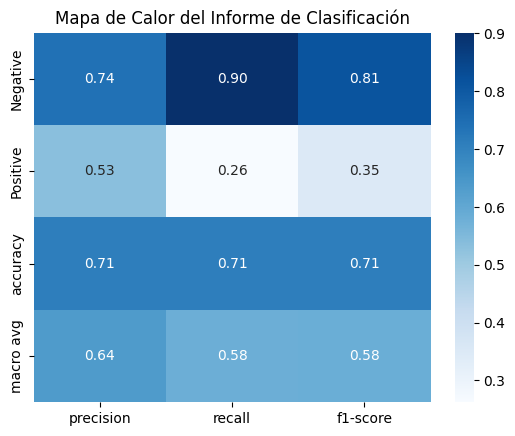

In [35]:
import seaborn as sns
report = classification_report(targets, predicted_classes, target_names=["Negative", "Positive"], output_dict=True)
df = pd.DataFrame(report).transpose()
sns.heatmap(df.iloc[:-1, :].drop(columns="support"), annot=True, cmap="Blues", fmt=".2f")
plt.title("Mapa de Calor del Informe de Clasificación")
plt.show()

**Explicación del Código**

````
Se calcula y muestra la matriz de confusión, que es una representación visual de las predicciones del modelo en comparación con las etiquetas reales.
Utiliza las funciones confusion_matrix() y plot_confusion_matrix() para generar y mostrar la matriz respectivamente.
La matriz se normaliza para resaltar las proporciones y mejorar la interpretación.
````

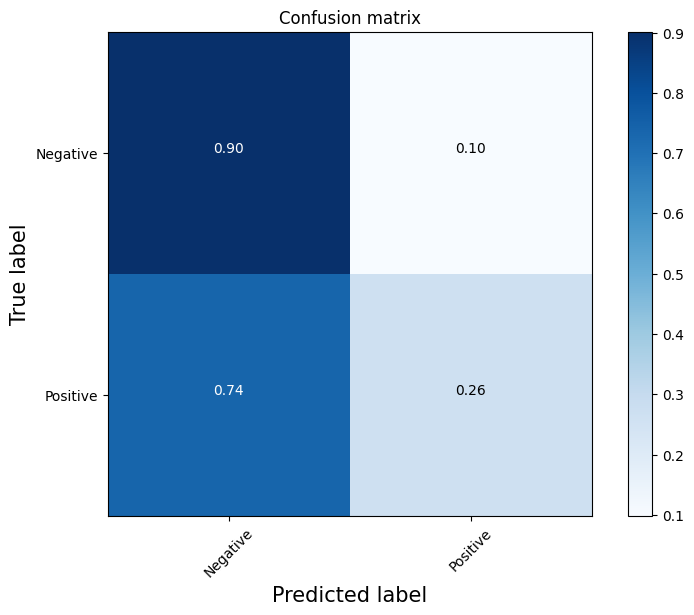

In [36]:
# print the confusion matrix
cnf_matrix = confusion_matrix(targets, predicted_classes, labels=[0, 1])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,classes=['Negative','Positive'],
    normalize=True,
    title='Confusion matrix'
)

**Explicación del Código**

````
En final, se realiza una evaluación visual comparativa entre tweets originales y limpios para las primeras entradas de un conjunto de datos.
Itera simultáneamente sobre los textos originales y limpios, así como sobre los valores objetivo reales ('targets') y
las predicciones del modelo ('predicted_classes'), limitando la visualización a los primeros 20 tweets originales y 20 tweets limpios.
Para cada conjunto de datos, imprime el texto original, el texto limpio, el valor objetivo y la predicción correspondiente.
Esta comparación permite verificar la eficacia de la limpieza del texto y evaluar preliminarmente la precisión de las predicciones del modelo respecto a los datos reales y procesados.
````

In [37]:
#visual evalution
for tweet, cleaned_tweet, target, output in zip(data_subset.text.values[:20], cleaned_data.text.values[:20], targets, predicted_classes):
  print(f"Original text: {tweet}")
  print(f"Text: {cleaned_tweet}")
  print(f"Target: {target}\tOutput: {output}\n")

Original text: @sport Y el barca que haria sin Messi????? Ni rotaciones le pueden dar.
Text: y el barca que haria sin messi ni rotaciones le pueden dar.
Target: 0	Output: 0

Original text: @RoussGame Te as enterado que an robado en la tienda del atleti
Creo que era la tienda. 
La verdad que hay poca vigilancia en vuestro estadio 
Y mañana tener cuidadito que e visto videos de los ultras rusos de mañana y son como los de bilbao
Text: te as enterado que an robado en la tienda del atleti creo que era la tienda. la verdad que hay poca vigilancia en vuestro estadio y tener cuidadito que e visto videos de los ultras rusos de y son como los de bilbao
Target: 0	Output: 0

Original text: Qué maravilla que este chico tocado por Dios, juegue en el Barça! Toda la historia que ha hecho Leo y toda la que le falta! EL MEJOR DE LA HISTORIA! https://t.co/WwnQZBVNvX
Text: maravilla que este chico tocado por dios, juegue en el toda la historia que ha hecho leo y toda la que le falta el mejor de la histor

# Celdas para explorar resultados

**Conclusiones**

El modelo de la parte 1(reviews) tiene un rendimiento general mucho mejor que el segundo. Se puede observar que las métricas de precisión, recall y f1-score para ambas clases (Negativo y Positivo) son bastante altas y equilibradas en comparación con el segundo modelo.

El modelo de la parte 1 también tiene una precisión global del 89%, mientras que el segundo modelo solo tiene una precisión global del 71%. Esto indica que el primer modelo es mucho más confiable en sus predicciones en comparación con el segundo.

El segundo modelo muestra un desequilibrio significativo entre las métricas de precisión, recall y f1-score para las clases Negativo y Positivo.
Mientras que el recall y f1-score para la clase Negativo son relativamente altos, son mucho más bajos para la clase Positivo, lo que indica que el modelo tiene dificultades para identificar correctamente las instancias de esa clase.

La diferencia en el soporte (número de instancias) entre los dos modelos también es notable. Mientras que el primer modelo se entrenó y evaluó en un conjunto de datos mucho más grande (50,000 instancias), el segundo modelo solo se evaluó en un conjunto de datos de 203 instancias. Esto puede indicar una posible falta de generalización del segundo modelo debido a su entrenamiento y evaluación en un conjunto de datos más pequeño.

Además, es importante destacar que los datos están desbalanceados. Los porcentajes de polaridad en el subconjunto de datos son: Negativo: 69.95%, Positivo: 30.05%. Este desequilibrio en la distribución de clases puede influir en el rendimiento de los modelos de análisis de sentimientos. Es probable que el desempeño del segundo modelo se vea afectado por este desbalance, ya que la clase Negativo está sobrerrepresentada en comparación con la clase Positivo. Esto puede explicar en parte por qué el segundo modelo tiene dificultades para identificar correctamente las instancias de la clase Positivo.

En resumen, el primer modelo es claramente superior al segundo en términos de rendimiento general, equilibrio entre clases y capacidad para generalizar a partir de un conjunto de datos más grande.

**Otras Razones del Rendimiento Inferior de Modelo Tweet**

Entender las razones subyacentes al rendimiento inferior del modelo de análisis de sentimientos en tweets, en comparación con el modelo más limpio y estructurado utilizado para revisiones de textos, es fundamental para mejorar la eficacia del algoritmo. Una de las principales diferencias radica en la naturaleza de los datos: los tweets, por su propia esencia, son menos estructurados y más variados en términos de longitud, estilo y contexto. Esta falta de uniformidad dificulta la extracción de características consistentes y relevantes para la clasificación de sentimientos.

Los tweets, a menudo, incluyen una serie de elementos como emojis, caracteres especiales, abreviaturas y jerga, que son menos comunes en textos más formales, como las revisiones de productos. La presencia de estos elementos agrega una capa de complejidad al proceso de análisis, ya que pueden introducir ruido y ambigüedad en los datos, lo que afecta la capacidad del modelo para comprender e interpretar el texto de manera adecuada.

Otro desafío significativo radica en la presencia de ironía, sarcasmo y humor sutil en los tweets. Estas formas de lenguaje son intrínsecamente difíciles de interpretar, incluso para los humanos, y representan un desafío aún mayor para los algoritmos de análisis de sentimientos. La ironía, en particular, puede ser malinterpretada por el modelo, lo que conduce a una clasificación errónea del sentimiento expresado en el texto.

Además, la naturaleza dinámica de las redes sociales contribuye a la rápida evolución del idioma y las tendencias de comunicación. Los tweets pueden contener neologismos, jerga emergente y referencias culturales contemporáneas que pueden no estar presentes en el conjunto de datos de entrenamiento del modelo. Esta discrepancia puede llevar a lagunas en la comprensión del texto y, por lo tanto, afectar negativamente la precisión de la clasificación de sentimientos.

Finalmente, la diversidad de opiniones, puntos de vista y estilos de escritura presentes en los tweets puede resultar en una mayor variabilidad en los datos. Esta variabilidad puede dar lugar a un conjunto de entrenamiento menos representativo y a un modelo menos capaz de generalizar para nuevos ejemplos. En contraste, los textos de revisión tienden a ser más estandarizados en términos de contenido y estructura, lo que facilita el proceso de aprendizaje del modelo.

La naturaleza más concisa de los tweets, que se caracteriza por tener menos verbos y frases más cortas en comparación con textos más largos y formales, también presenta un desafío adicional. Además, el lenguaje informal y el uso de abreviaturas son más comunes en este tipo de comunicación. Esta densidad de información y estructura más condensada puede plantear desafíos adicionales para el análisis de sentimientos.

Por lo tanto, la combinación de estos factores contribuye a la complejidad y desafíos únicos asociados con el análisis de sentimientos en tweets, lo que resulta en un rendimiento inferior en comparación con el análisis de textos más formales y estructurados.

Con eso....

Desarrollé una función para abordar los desafíos específicos del análisis de sentimientos en tweets. Esta función extrae características adicionales de los tweets utilizando herramientas de procesamiento de lenguaje natural como la tokenización de palabras y la etiquetación gramatical. Además de contar emojis y caracteres especiales, la función calcula la longitud del texto, el número de frases, la cantidad de símbolos de puntuación y verifica la presencia de enlaces web.

Estas características adicionales proporcionan una visión más completa de la estructura y el contenido de los tweets. Al integrar estas herramientas en el proceso de análisis, espero mejorar la capacidad de nuestro modelo para realizar un análisis de sentimientos más preciso y efectivo en este tipo de datos.

In [45]:
import re
import string
import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize

# Descargar recursos necesarios para NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
print("\n")

# Función para contar caracteres especiales
def contar_caracteres_especiales(texto):
    conteo_arroba = texto.count('@')
    conteo_http = texto.count('http')
    conteo_hashtag = texto.count('#')
    return conteo_arroba, conteo_http, conteo_hashtag

# Función para contar emojis
def contar_emojis(texto):
    # Definir los rangos de códigos Unicode para diferentes tipos de emojis
    patron_emoji = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Símbolos y pictogramas
                               u"\U0001F680-\U0001F6FF"  # Transporte y símbolos de mapa
                               u"\U0001F700-\U0001F77F"  # Símbolos alquímicos
                               u"\U0001F780-\U0001F7FF"  # Formas geométricas estendidas
                               u"\U0001F800-\U0001F8FF"  # Setas suplementares-C
                               u"\U0001F900-\U0001F9FF"  # Símbolos y pictogramas suplementares
                               u"\U0001FA00-\U0001FA6F"  # Símbolos de xadrez
                               u"\U0001FA70-\U0001FAFF"  # Símbolos e pictogramas estendidos-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"  # Caracteres encapsulados
                               u"\U0000200D"             # Junção de largura zero
                               u"\U0001F1E0-\U0001F1FF"  # Bandeiras (iOS)
                               u"\U00002500-\U00002BEF"  # Caracteres chineses
                               u"\U0001F90D-\U0001F9FF"  # Símbolos e pictogramas suplementares adicionais
                               u"\U0001F004-\U0001F0CF"  # Peças de mahjong + cartas de jogar
                               u"\U0001F3C0-\U0001F3FF"  # Símbolos esportivos
                               u"\U0001F9C0-\U0001F9FF"  # Comida e bebida
                               u"\U0001FAD0-\U0001FAFF"  # Símbolos estendidos parte 3
                               u"\U00002600-\U000026FF"  # Símbolos diversos
                               u"\U00002700-\U000027BF"  # Dingbats estendidos
                               "]+", flags=re.UNICODE)
    return len(patron_emoji.findall(texto))

# Función para extraer características adicionales de los tweets
def características_adicionales(texto):
    # Contar caracteres especiales
    conteo_arroba, conteo_http, conteo_hashtag = contar_caracteres_especiales(texto)

    # Contar emojis
    conteo_emojis = contar_emojis(texto)

    # Contar símbolos de puntuación
    conteo_puntuación = sum([1 for char in texto if char in string.punctuation])

    # Longitud del texto (número de caracteres)
    longitud_texto = len(texto)

    # Número de frases
    frases = sent_tokenize(texto)
    num_frases = len(frases)

    # Número de espacios en blanco
    conteo_espacios = texto.count(' ')

    # Líneas en blanco (líneas en blanco entre párrafos)
    lineas_vacias = texto.count('\n\n')

    # Tokenización de palabras y conteo de etiquetas POS
    tokens = word_tokenize(texto)
    etiquetas_pos = pos_tag(tokens)
    conteo_verbos = len([palabra for palabra, pos in etiquetas_pos if pos.startswith('VB')])
    conteo_adjetivos = len([palabra for palabra, pos in etiquetas_pos if pos.startswith('JJ')])
    conteo_sustantivos = len([palabra for palabra, pos in etiquetas_pos if pos.startswith('NN')])

    # Contar enlaces www
    conteo_www = len(re.findall(r'www\.[^\s]+', texto))

    # Devolver todas las características
    return conteo_arroba, conteo_http, conteo_hashtag, conteo_emojis, conteo_puntuación, longitud_texto, num_frases, conteo_espacios, lineas_vacias, conteo_verbos, conteo_adjetivos, conteo_sustantivos, conteo_www

# Evaluación visual
for tweet, tweet_limpio, objetivo, salida in zip(data_subset.text.values[:20], cleaned_data.text.values[:20], targets, predicted_classes):
    # Extraer características adicionales del tweet
    conteo_arroba, conteo_http, conteo_hashtag, conteo_emojis, conteo_puntuación, longitud_texto, num_frases, conteo_espacios, lineas_vacias, conteo_verbos, conteo_adjetivos, conteo_sustantivos, conteo_www = características_adicionales(tweet)

    # Imprimir las características adicionales
    print(f"Texto original: {tweet}")
    print("\n")
    print(f"Conteo de '@': {conteo_arroba}")
    print(f"Conteo de 'http': {conteo_http}")
    print(f"Conteo de '#': {conteo_hashtag}")
    print(f"Conteo de emojis: {conteo_emojis}")
    print(f"Conteo de símbolos de puntuación: {conteo_puntuación}")
    print(f"Longitud del texto: {longitud_texto}")
    print(f"Número de frases: {num_frases}")
    print(f"Número de espacios en blanco: {conteo_espacios}")
    print(f"Número de líneas en blanco: {lineas_vacias}")
    print(f"Número de verbos: {conteo_verbos}")
    print(f"Número de adjetivos: {conteo_adjetivos}")
    print(f"Número de sustantivos: {conteo_sustantivos}")
    print(f"Número de enlaces www: {conteo_www}\n")




Texto original: @sport Y el barca que haria sin Messi????? Ni rotaciones le pueden dar.


Conteo de '@': 1
Conteo de 'http': 0
Conteo de '#': 0
Conteo de emojis: 0
Conteo de símbolos de puntuación: 7
Longitud del texto: 71
Número de frases: 2
Número de espacios en blanco: 12
Número de líneas en blanco: 0
Número de verbos: 2
Número de adjetivos: 3
Número de sustantivos: 9
Número de enlaces www: 0

Texto original: @RoussGame Te as enterado que an robado en la tienda del atleti
Creo que era la tienda. 
La verdad que hay poca vigilancia en vuestro estadio 
Y mañana tener cuidadito que e visto videos de los ultras rusos de mañana y son como los de bilbao


Conteo de '@': 1
Conteo de 'http': 0
Conteo de '#': 0
Conteo de emojis: 0
Conteo de símbolos de puntuación: 2
Longitud del texto: 241
Número de frases: 2
Número de espacios en blanco: 44
Número de líneas en blanco: 0
Número de verbos: 0
Número de adjetivos: 2
Número de sustantivos: 29
Número de enlaces www: 0

Texto original: Qué maravi

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
